# Deep Learning Course

## Recurrent Neural Networks (RNNs)

## Dataset: WISDM AR [Source: Wireless Sensor Data Mining](https://www.cis.fordham.edu/wisdm/dataset.php)

**Implementation of Various Recurrent Neural Networks**

A series of recurrent neural networks (LSTM, GRU, Bidirectional LSTM, Bidirectional GRU) are implemented for the classification of the WISDM AR dataset. 

A small hyperparameter tuning is performed for each model and subsequently, the various models are evaluated on the test set to verify their accuracy.

The parameter optimization mainly concerns the number of units for each layer and the learning rate.

In [ ]:
# Libraries used

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

The **WISDM AR** (Wireless Sensor Data Mining for Activity Recognition) dataset contains data on measurements from mobile device sensors for human activity recognition. 

More informations are available in the wisdm_ar directory:
- [readme.txt](wisdm_ar/readme.txt): _info about the WISDM Lab_,
- [WISDM_ar_v1.1_raw_about.txt](wisdm_ar/WISDM_ar_v1.1_raw_about.txt): _info about the dataset_.

We will work on 5 classes instead of 6, combining stair climbing and descent.

| Label | Activity      |
|------|---------------|
| 0    | Walking       |
| 1    | Jogging       |
| 2    | Upstairs/Downstairs      |
| 3    | Sitting       |
| 4    | Standing      |

In [ ]:
# Cleaning and download WISDM AR dataset

with open("WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", 'r') as f:
    content = f.read()

content = content.replace(",;", ";")
content = content.replace(";", ";\n")
content = content.replace(";", "")
lines = [line for line in content.split("\n") if line.strip()]


with open("WISDM_ar_v1.1/WISDM_ar_v1.1_cleaned.txt", "w") as f:
    f.write("\n".join(lines))

wisdm_ar = pd.read_csv("WISDM_ar_v1.1/WISDM_ar_v1.1_cleaned.txt", 
                       names=["user", "activity", "timestamp", "x-acc", "y-acc", "z-acc"],
                       sep=",")

wisdm_ar = wisdm_ar.dropna()

In [ ]:
X = []
y = []
window_size = 50    # 1 sample every 50ms -> 50 samples = 2.5s
step_size = 25         

activities = {"Walking": 0, 
              "Jogging": 1, 
              "Uptairs/Downstairs": 2, 
              "Sitting": 3, 
              "Standing": 4}

for (user, activity), group in wisdm_ar.groupby(["user", "activity"]):
    if activity == "Upstairs" or activity == "Downstairs":
        activity = "Uptairs/Downstairs"
    
    x_data = group["x-acc"].values
    y_data = group["y-acc"].values
    z_data = group["z-acc"].values
    
    segments = max(0, (len(x_data) - window_size) // step_size + 1)
    
    for i in range(segments):
        start = i * step_size
        end = start + window_size
        
        if end <= len(x_data):
            segment = np.column_stack([
                x_data[start:end],
                y_data[start:end],
                z_data[start:end]
            ])
            
            X.append(segment)
            
            label = np.zeros(len(activities))
            label[activities[activity]] = 1
            y.append(label)
        
X = np.array(X); X = X.astype("float32")
y = np.array(y); y = y.astype("float32")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=21)

print("Shape:")
print(f"    Training set   -> {x_train.shape}")
print(f"    Labels         -> {y_train.shape}")
print(f"    Validation set -> {x_val.shape}")
print(f"    Test set       -> {x_test.shape}\n")
print("Data example:")

for i, axis in enumerate(["x_axis", "y_axis", "z_axis"]):
    print(f"{axis}: {x_train[0, :, i]}")
    print("\n")
    
labels = ["Walking", "Jogging", "Uptairs/Downstairs", "Sitting", "Standing"]
id = np.argmax(y_train[0])
print(f"Activity: {y_train[0]} -> {labels[id]}")

Shape:
    Training set   -> (31437, 50, 3)
    Labels         -> (31437, 5)
    Validation set -> (3494, 50, 3)
    Test set       -> (8733, 50, 3)

Data example:
x_axis: [ 8.54  8.5   9.19  9.43 12.18 15.09 11.35 14.44  7.25  6.82  5.56  4.21
  0.04  3.95 18.96 13.59  8.05  7.5   6.13  7.67  7.63  8.58  8.39  8.24
  8.47  9.19  9.   11.5  16.55 11.92 14.67  8.01  6.55  6.21  5.56  1.88
 -0.42 10.99 19.57  4.02 13.67  5.79  6.21  9.62  6.85  7.55  8.77  9.11
  9.53  8.73]


y_axis: [ 3.3   3.41  4.14  4.06  3.95 -0.04  6.13 14.41  7.5   3.45  4.33  5.28
  6.59  2.37 -2.98 -0.84 11.37  6.89  7.7   7.46  5.05  4.9   4.25  3.26
  3.06  3.68  3.72  3.26  0.31  4.18 11.14 12.07  6.66  3.15  5.22  5.01
  4.63  0.61 -3.3   2.11 15.36  6.32  5.41  7.35  4.75  4.6   4.18  2.79
  3.26  3.15]


z_axis: [ 0.6946377  -0.50395286 -0.19068487  1.6480621   3.2961242   1.8387469
  1.1168685  -5.243834    3.3778462  -2.1792557  -0.46309182 -0.88532263
 -0.27240697  1.1441092  -0.23154591  2.7649305  -4

In [43]:
# Standardization

x_train_reshaped = x_train.reshape(-1, 3) 

scaler = StandardScaler()
scaler.fit(x_train_reshaped)  

x_train_standardized = scaler.transform(x_train_reshaped)
x_train = x_train_standardized.reshape(x_train.shape)

x_val_reshaped = x_val.reshape(-1, 3)
x_val_standardized = scaler.transform(x_val_reshaped)
x_val = x_val_standardized.reshape(x_val.shape)

x_test_reshaped = x_test.reshape(-1, 3)
x_test_standardized = scaler.transform(x_test_reshaped)
x_test = x_test_standardized.reshape(x_test.shape)

Hyperparameter tuning of:
- **LSTM**
- **GRU**
- **Bidirectional(LSTM)**
- **Bidirectional(GRU)**

In [7]:
# LSTM

def model_builder_LSTM(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(x_train.shape[1], 
                                    x_train.shape[2])))
    
    units = hp.Choice("units_1", values=[32,64])
    dropout = hp.Choice("dropout_1", values=[0.0, 0.25, 0.5])
    model.add(tf.keras.layers.LSTM(units=units, 
                                   recurrent_dropout=dropout, 
                                   return_sequences=True))
    
    units = hp.Choice("units_2", values=[32,64])
    dropout = hp.Choice("dropout_2", values=[0.0, 0.25, 0.5])
    model.add(tf.keras.layers.LSTM(units=units, 
                                   recurrent_dropout=dropout, 
                                   return_sequences=False))
    
    model.add(tf.keras.layers.Dense(units=5, 
                                    activation="softmax"))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    return model

tuner_LSTM = kt.Hyperband(model_builder_LSTM, 
                          objective="val_accuracy", 
                          max_epochs=30, 
                          directory="Tuning", 
                          project_name="LSTM", 
                          hyperband_iterations=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience = 3)

tuner_LSTM.search(x_train, 
                  y_train, 
                  epochs=10,
                  batch_size=128, 
                  validation_data=(x_val, y_val), 
                  callbacks=[early_stopping])

best_hp_LSTM = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
print(f"    Units 1st layer -> {best_hp_LSTM.get('units_1')}")
print(f"    Dropout %       -> {best_hp_LSTM.get('dropout_1')}")
print(f"    Units 2nd layer -> {best_hp_LSTM.get('units_2')}")
print(f"    Dropout %       -> {best_hp_LSTM.get('dropout_2')}")
print(f"Accuracy -> {tuner_LSTM.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\LSTM\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters found:
    Units 1st layer -> 64
    Dropout %       -> 0.25
    Units 2nd layer -> 32
    Dropout %       -> 0.0
Accuracy -> 0.9722381234169006


In [8]:
# GRU

def model_builder_GRU(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(x_train.shape[1], 
                                    x_train.shape[2])))
    
    units = hp.Choice("units_1", values=[32,64])
    dropout = hp.Choice("dropout_1", values=[0.0, 0.25, 0.5])
    model.add(tf.keras.layers.GRU(units=units, 
                                  dropout=dropout, 
                                  return_sequences=True))
    
    units = hp.Choice("units_2", values=[8, 16])
    dropout = hp.Choice("dropout_2", values=[0.0, 0.25, 0.5])
    model.add(tf.keras.layers.LSTM(units=units, 
                                   dropout=dropout, 
                                   return_sequences=False))
    
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    return model

tuner_GRU = kt.Hyperband(model_builder_GRU, 
                         objective="val_accuracy", 
                         max_epochs=30, 
                         directory="Tuning", 
                         project_name="GRU", 
                         hyperband_iterations=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience = 3)

tuner_GRU.search(x_train, 
                 y_train, 
                 epochs=30, 
                 batch_size=128,
                 validation_data=(x_val, y_val), 
                 callbacks=[early_stopping])

best_hp_GRU = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
print(f"    Units 1st layer -> {best_hp_GRU.get('units_1')}")
print(f"    Dropout %       -> {best_hp_GRU.get('dropout_1')}")
print(f"    Units 2nd layer -> {best_hp_GRU.get('units_2')}")
print(f"    Dropout %       -> {best_hp_GRU.get('dropout_2')}")
print(f"Accuracy -> {tuner_GRU.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\GRU\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters found:
    Units 1st layer -> 64
    Dropout %       -> 0.0
    Units 2nd layer -> 16
    Dropout %       -> 0.25
Accuracy -> 0.9705209136009216


In [9]:
# Bidirectional (only LSTM)

def model_builder_BidirectionalLSTM(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(x_train.shape[1], 
                                    x_train.shape[2])))
    
    units = hp.Choice("units_1", values=[32, 64])
    dropout = hp.Choice("dropout_1", values=[0.0, 0.25, 0.5])
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=units,
                                                                 recurrent_dropout=dropout,
                                                                 return_sequences=False)))
    
    units = hp.Choice("units_2", values=[16, 32])                                                           
    model.add(tf.keras.layers.Dense(units=units, 
                                    activation="relu"))
    
    dropout = hp.Choice("dropout_2", values=[0.0, 0.25])
    model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    return model

tuner_BidirectionalLSTM = kt.Hyperband(model_builder_BidirectionalLSTM, 
                                       objective="val_accuracy", 
                                       max_epochs=30, 
                                       directory="Tuning", 
                                       project_name="Bidirectional_LSTM", 
                                       hyperband_iterations=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=3)

tuner_BidirectionalLSTM.search(x_train, 
                               y_train, 
                               epochs=30, 
                               batch_size=128,
                               validation_data=(x_val, y_val), 
                               callbacks=[early_stopping])

best_hp_BidirectionalLSTM = tuner_BidirectionalLSTM.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
print(f"    Units 1st layer -> {best_hp_BidirectionalLSTM.get('units_1')}")
print(f"    Dropout %       -> {best_hp_BidirectionalLSTM.get('dropout_1')}")
print(f"    Units 2nd layer -> {best_hp_BidirectionalLSTM.get('units_2')}")
print(f"    Dropout %       -> {best_hp_BidirectionalLSTM.get('dropout_2')}")
print(f"Accuracy -> {tuner_BidirectionalLSTM.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\Bidirectional_LSTM\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters found:
    Units 1st layer -> 64
    Dropout %       -> 0.0
    Units 2nd layer -> 16
    Dropout %       -> 0.0
Accuracy -> 0.9645105600357056


In [10]:
# Bidirectional (only GRU)

def model_builder_BidirectionalGRU(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(x_train.shape[1], 
                                    x_train.shape[2])))
    
    units = hp.Choice("units_1", values=[32, 64])
    dropout = hp.Choice("dropout_1", values=[0.0, 0.25, 0.5])
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=units,
                                                                recurrent_dropout=dropout,
                                                                return_sequences=False)))
    
    units = hp.Choice("units_2", values=[16, 32])                                                           
    model.add(tf.keras.layers.Dense(units=units, 
                                    activation="relu"))
    
    dropout = hp.Choice("dropout_2", values=[0.0, 0.25])
    model.add(tf.keras.layers.Dropout(dropout))
    
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    return model

tuner_BidirectionalGRU = kt.Hyperband(model_builder_BidirectionalGRU, 
                                      objective="val_accuracy", 
                                      max_epochs=30, 
                                      directory="Tuning", 
                                      project_name="Bidirectional_GRU", 
                                      hyperband_iterations=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=3)

tuner_BidirectionalGRU.search(x_train, 
                              y_train, 
                              epochs=30, 
                              batch_size=128,
                              validation_data=(x_val, y_val), 
                              callbacks=[early_stopping])

best_hp_BidirectionalGRU = tuner_BidirectionalGRU.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
print(f"    Units 1st layer -> {best_hp_BidirectionalGRU.get('units_1')}")
print(f"    Dropout %       -> {best_hp_BidirectionalGRU.get('dropout_1')}")
print(f"    Units 2nd layer -> {best_hp_BidirectionalGRU.get('units_2')}")
print(f"    Dropout %       -> {best_hp_BidirectionalGRU.get('dropout_2')}")
print(f"Accuracy -> {tuner_BidirectionalGRU.oracle.get_best_trials(1)[0].score}")

INFO:tensorflow:Reloading Tuner from Tuning\Bidirectional_GRU\tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters found:
    Units 1st layer -> 64
    Dropout %       -> 0.0
    Units 2nd layer -> 32
    Dropout %       -> 0.0
Accuracy -> 0.9713795185089111


After the tuning we can build the final models.

We define the same callback for every models, we also create a directory to save the models and some dictionaries for the results.

In [ ]:
# directory

dir = "Models"
path_dir = os.path.join(os.getcwd(), dir)

if not os.path.exists(path_dir):
    os.makedirs(path_dir)

 
# callback

early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                       patience = 3,
                                                       restore_best_weights=True)

# dictionaries 

models = ["LSTM", "GRU", "BidirectionalLSTM", "BidirectionalGRU"]

results = {}
histories = {}

In [26]:
# LSTM

LSTM_model = tf.keras.Sequential(name="LSTM_MODEL", layers=[
    tf.keras.Input(shape=(x_train.shape[1], 
                          x_train.shape[2])),
    
    tf.keras.layers.LSTM(name="LSTM_1",
                         units=best_hp_LSTM.get("units_1"),
                         recurrent_dropout=best_hp_LSTM.get("dropout_1"),
                         return_sequences=True),
    
    tf.keras.layers.LSTM(name="LSTM_2",
                         units=best_hp_LSTM.get("units_2"),
                         recurrent_dropout=best_hp_LSTM.get("dropout_2")),
    
    tf.keras.layers.Dense(name="Output",
                          units=5,
                          activation="softmax")
])

optimizer_LSTM = tf.keras.optimizers.Adam(learning_rate=0.01)

LSTM_model.compile(optimizer=optimizer_LSTM, 
                   loss="categorical_crossentropy", 
                   metrics=["accuracy"])

LSTM_model.summary()

Model: "LSTM_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 50, 64)            17408     
                                                                 
 LSTM_2 (LSTM)               (None, 32)                12416     
                                                                 
 Output (Dense)              (None, 5)                 165       
                                                                 
Total params: 29,989
Trainable params: 29,989
Non-trainable params: 0
_________________________________________________________________


In [27]:
# GRU

GRU_model = tf.keras.Sequential(name="GRU_MODEL", layers=[
    tf.keras.Input(shape=(x_train.shape[1], 
                          x_train.shape[2])),
    
    tf.keras.layers.GRU(name="GRU_1",
                        units=best_hp_GRU.get("units_1"),
                        recurrent_dropout=best_hp_GRU.get("dropout_1"),
                        return_sequences=True),
    
    tf.keras.layers.GRU(name="GRU_2",
                        units=best_hp_GRU.get("units_2"),
                        recurrent_dropout=best_hp_GRU.get("dropout_2")),
    
    tf.keras.layers.Dense(name="output",
                          units=5,
                          activation="softmax")
])

optimizer_GRU = tf.keras.optimizers.Adam(learning_rate=0.01)

GRU_model.compile(optimizer=optimizer_GRU, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

GRU_model.summary()

Model: "GRU_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU_1 (GRU)                 (None, 50, 64)            13248     
                                                                 
 GRU_2 (GRU)                 (None, 16)                3936      
                                                                 
 output (Dense)              (None, 5)                 85        
                                                                 
Total params: 17,269
Trainable params: 17,269
Non-trainable params: 0
_________________________________________________________________


In [28]:
# BidirectionaLSTM

BidirectionaLSTM_model = tf.keras.Sequential(name="BIDIRECTIONAL_LSTM_MODEL", layers=[
    tf.keras.Input(shape=(x_train.shape[1], 
                          x_train.shape[2])),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(name="BIDIRECTIONAL_LSTM",
                                                       units=best_hp_BidirectionalLSTM.get("units_1"),
                                                       recurrent_dropout=best_hp_BidirectionalLSTM.get("dropout_1"))),
    
    tf.keras.layers.Dense(name="Dense",
                          units=best_hp_BidirectionalLSTM.get("units_2")),
    
    tf.keras.layers.Dropout(name="Dropout",
                            rate=best_hp_BidirectionalLSTM.get("dropout_2")),
    
    tf.keras.layers.Dense(name="output",
                          units=5,
                          activation="softmax")
])

optimizer_BLSTM = tf.keras.optimizers.Adam(learning_rate=0.01)

BidirectionaLSTM_model.compile(optimizer=optimizer_BLSTM, 
                               loss="categorical_crossentropy", 
                               metrics=["accuracy"])

BidirectionaLSTM_model.summary()

Model: "BIDIRECTIONAL_LSTM_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128)              34816     
 nal)                                                            
                                                                 
 Dense (Dense)               (None, 16)                2064      
                                                                 
 Dropout (Dropout)           (None, 16)                0         
                                                                 
 output (Dense)              (None, 5)                 85        
                                                                 
Total params: 36,965
Trainable params: 36,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# BidirectionaGRU

BidirectionaGRU_model = tf.keras.Sequential(name="BIDIRECTIONAL_GRU_MODEL", layers=[
    tf.keras.Input(shape=(x_train.shape[1], 
                          x_train.shape[2])),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(name="BIDIRECTIONAL_GRU",
                                                      units=best_hp_BidirectionalGRU.get("units_1"),
                                                      recurrent_dropout=best_hp_BidirectionalGRU.get("dropout_1"))),
    
    tf.keras.layers.Dense(name="Dense",
                          units=best_hp_BidirectionalGRU.get("units_2")),
    
    tf.keras.layers.Dropout(name="Dropout",
                            rate=best_hp_BidirectionalGRU.get("dropout_2")),
    
    tf.keras.layers.Dense(name="output",
                          units=5,
                          activation="softmax")
])

optimizer_BGRU = tf.keras.optimizers.Adam(learning_rate=0.01)

BidirectionaGRU_model.compile(optimizer=optimizer_BGRU, 
                              loss="categorical_crossentropy", 
                              metrics=["accuracy"])

BidirectionaGRU_model.summary()

Model: "BIDIRECTIONAL_GRU_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 128)              26496     
 nal)                                                            
                                                                 
 Dense (Dense)               (None, 32)                4128      
                                                                 
 Dropout (Dropout)           (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                 165       
                                                                 
Total params: 30,789
Trainable params: 30,789
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Validation test evaluation

for model_name in models:
    if model_name == "LSTM":
        model = LSTM_model
    elif model_name == "GRU":
        model = GRU_model
    elif model_name == "BidirectionalLSTM":
        model = BidirectionaLSTM_model
    elif model_name == "BidirectionalGRU":
        model = BidirectionaGRU_model
        
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"Models/best_{model_name}_model.keras",   
                                                    monitor="val_loss",    
                                                    save_best_only=True,        
                                                    mode="min",                 
                                                    verbose=1)
    print(f"{model_name} fit:")
    histories[model_name] = model.fit(x_train, 
                                      y_train, 
                                      epochs=20, 
                                      batch_size=128, 
                                      validation_data=(x_val, y_val),
                                      callbacks=[checkpoint, early_stopping_loss])
    
    val_loss, val_accuracy = model.evaluate(x_val, y_val)

    results[model_name] = (val_loss, val_accuracy)

LSTM fit:
Epoch 1/20
246/246 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8400
Epoch 1: val_loss improved from inf to 0.19582, saving model to Models\best_LSTM_model.keras
246/246 [==============================] - 33s 107ms/step - loss: 0.4412 - accuracy: 0.8400 - val_loss: 0.1958 - val_accuracy: 0.9359
Epoch 2/20
246/246 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9461
Epoch 2: val_loss improved from 0.19582 to 0.12635, saving model to Models\best_LSTM_model.keras
246/246 [==============================] - 26s 104ms/step - loss: 0.1737 - accuracy: 0.9461 - val_loss: 0.1263 - val_accuracy: 0.9619
Epoch 3/20
246/246 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9674
Epoch 3: val_loss improved from 0.12635 to 0.08906, saving model to Models\best_LSTM_model.keras
246/246 [==============================] - 26s 104ms/step - loss: 0.1054 - accuracy: 0.9674 - val_loss: 0.0891 - val_accuracy: 0.9737
Epoch 4/20
24

In [31]:
# Results

print(f"{'Model':^20} | {'Val Loss':^10} | {'Val Accuracy':^10}")
print("-" * 46)  

sorted_models = sorted(models, 
                       key=lambda x: results[x][1], 
                       reverse=True)

for model in sorted_models:
    print(f"{model:^20} | {results[model][0]:^10.4f} | {results[model][1]:^10.4f}")

       Model         |  Val Loss  | Val Accuracy
----------------------------------------------
        LSTM         |   0.0340   |   0.9908  
 BidirectionalLSTM   |   0.0425   |   0.9874  
  BidirectionalGRU   |   0.0504   |   0.9860  
        GRU          |   0.0555   |   0.9851  


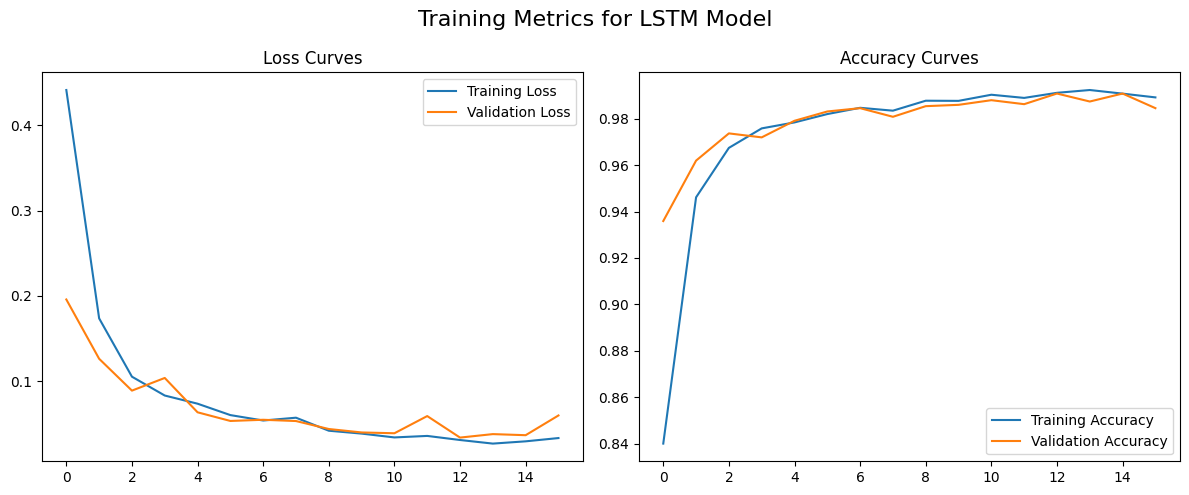

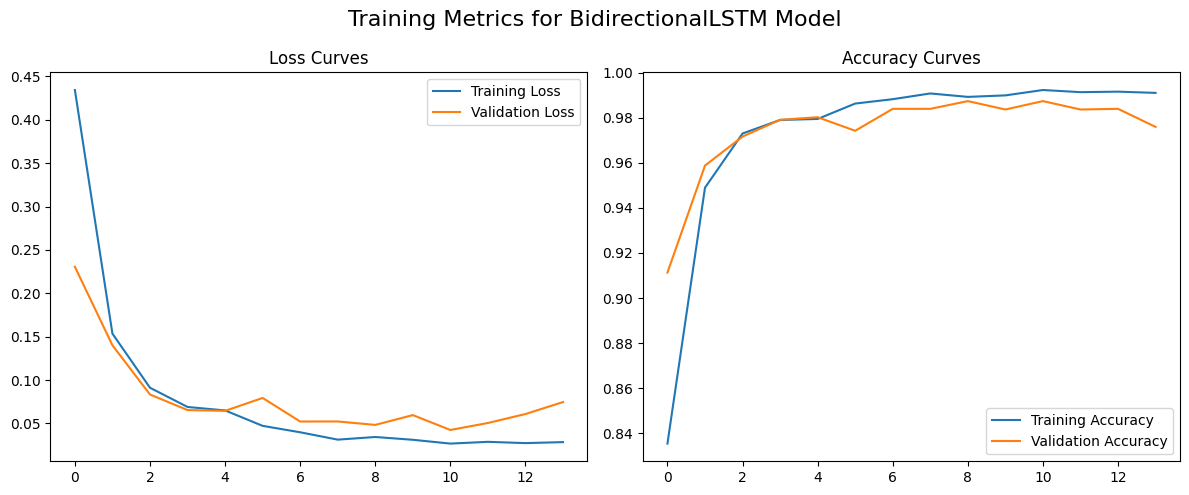

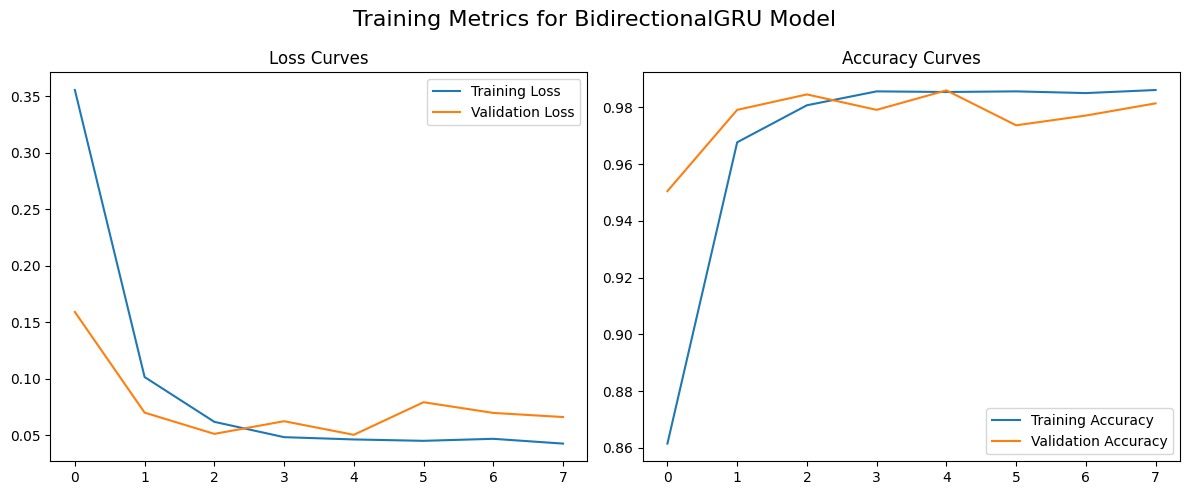

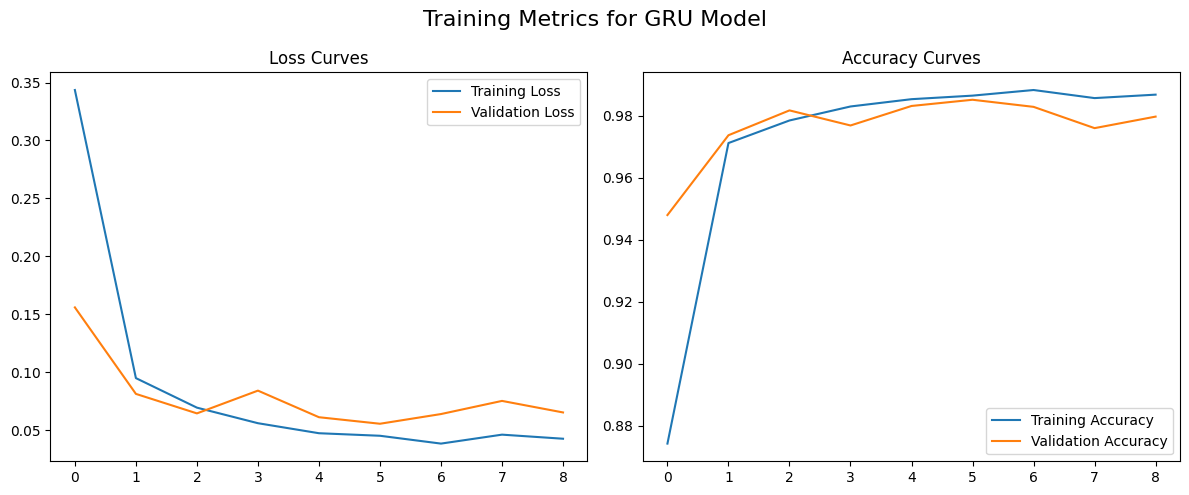

In [32]:
# Overfitting

for model in sorted_models:
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Training Metrics for {model} Model", fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(histories[model].history["loss"], label="Training Loss")
    plt.plot(histories[model].history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Loss Curves")

    plt.subplot(1, 2, 2)
    plt.plot(histories[model].history["accuracy"], label="Training Accuracy")
    plt.plot(histories[model].history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy Curves")

    plt.tight_layout()
    plt.show()

In [ ]:
# Re-training on training + validation

x_train_val = np.concatenate([x_train, x_val], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

accuracies = {}

for model_name in sorted_models:
    best_model = tf.keras.models.load_model(f"Models/best_{model_name}_model.keras")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"Models/final_{model_name}_model.keras",   
                                                    monitor="accuracy",    
                                                    save_best_only=True,        
                                                    mode="max",                 
                                                    verbose=1)
    
    best_model.fit(x_train_val, 
            y_train_val, 
            epochs=20,
            batch_size=128,
            callbacks=[checkpoint])
    
    prediction = best_model.predict(x_test)
    predicted_labels = np.argmax(prediction, axis=1)
    accuracies[model_name] = accuracy_score(np.argmax(y_test, axis=1), predicted_labels)

Epoch 1/20
273/273 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9907
Epoch 1: accuracy improved from -inf to 0.99067, saving model to Models\final_LSTM_model.keras
273/273 [==============================] - 34s 110ms/step - loss: 0.0318 - accuracy: 0.9907
Epoch 2/20
273/273 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9916
Epoch 2: accuracy improved from 0.99067 to 0.99158, saving model to Models\final_LSTM_model.keras
273/273 [==============================] - 30s 110ms/step - loss: 0.0282 - accuracy: 0.9916
Epoch 3/20
273/273 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9875
Epoch 3: accuracy did not improve from 0.99158
273/273 [==============================] - 29s 108ms/step - loss: 0.0420 - accuracy: 0.9875
Epoch 4/20
273/273 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9913
Epoch 4: accuracy did not improve from 0.99158
273/273 [==============================] - 29s 108ms/

In [66]:
# Results

print(f"{'Model':^20} | {'Accuracy':^10}")
print("-" * 33)  

sorted_accuracies = sorted(accuracies, 
                           key=lambda x: accuracies[x], 
                           reverse=True)

for model in sorted_accuracies:
    print(f"{model:^20} | {accuracies[model]:^10.4f}")

       Model         |  Accuracy 
---------------------------------
        LSTM         |   0.9932  
 BidirectionalLSTM   |   0.9899  
  BidirectionalGRU   |   0.9670  
        GRU          |   0.9430  
